In [1]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow as tf
import numpy as np

import datetime
import matplotlib.pyplot as plt

import cv2
import pandas as pd

import sklearn
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import torch
from torch.autograd import Variable
from PIL import Image

import time, math

%matplotlib inline
np.random.seed(42)

In [14]:
model_torch = torch.load("model_epoch_50.pth")["model"]
model_torch = model_torch.cpu()

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set 

In [2]:
mnist = keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

#x_train = x_train / 255
#x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 28, 28, 1) (10000, 10) (60000, 28, 28, 1) (60000, 10)


In [4]:
x_train_rgb = np.zeros((60000,28,28,3),np.float32)
x_test_rgb = np.zeros((10000,28,28,3),np.float32)

for i in range(60000):
  x_train_rgb[i] = cv2.cvtColor(x_train[i], cv2.COLOR_GRAY2RGB) / 255

for i in range(10000): 
  x_test_rgb[i] = cv2.cvtColor(x_test[i], cv2.COLOR_GRAY2RGB) / 255

print("Data shapes", x_test_rgb.shape, y_test.shape, x_train_rgb.shape, y_train.shape)

Data shapes (10000, 28, 28, 3) (10000, 10) (60000, 28, 28, 3) (60000, 10)


In [5]:
def res_block(x,filter,stride,name):
    input = x
    if stride != 1:
        input = tf.keras.layers.Conv2D(filters=filter,kernel_size=1,strides=stride,name=name+'_pooling_conv')(input)
        input = tf.keras.layers.BatchNormalization(name=name+'_pooling_bn')(input)

    x = tf.keras.layers.Conv2D(filters=filter,kernel_size=1,strides=stride,padding='same',name=name+'_conv1')(x)
    x = tf.keras.layers.BatchNormalization(name=name+'_bn1')(x)
    x = tf.nn.relu(x,name=name+'_relu1')

    x = tf.keras.layers.Conv2D(filters=filter,kernel_size=1,strides=1,padding='same',name=name+'_conv2')(x)
    x = tf.keras.layers.BatchNormalization(name=name+'_bn2')(x)
    x = tf.keras.layers.add([input,x],name=name+'_add')

    x = tf.nn.relu(x,name=name+'_relu2')
    return x

In [6]:
inputs = keras.Input(shape=(28, 28, 3), name="train_images")

#start
x = tf.keras.layers.Conv2D(filters=64,kernel_size=7,strides=2,activation='relu',padding='same',name='conv1')(inputs)
x = tf.keras.layers.BatchNormalization(name='conv1_bn')(x)
x = tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding='same',name='conv1_max_pool')(x)

x = res_block(x,64,2,'ResBlock1') 

x = res_block(x,64,1,'ResBlock2')

x = res_block(x,128,2,'ResBlock3')

x = res_block(x,128,1,'ResBlock4')

x = tf.keras.layers.GlobalAveragePooling2D(name='GAP')(x) 

pred = tf.keras.layers.Dense(10,activation='softmax')(x)

model = keras.Model(inputs, pred, name="toy_resnet")

model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
train_images (InputLayer)       [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 64)   9472        train_images[0][0]               
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 14, 14, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_max_pool (MaxPooling2D)   (None, 7, 7, 64)     0           conv1_bn[0][0]                   
_________________________________________________________________________________________

In [7]:
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

resnet = model.fit(x_train_rgb,y_train,
                    batch_size=32,
                    epochs=10,
                    shuffle=True,
                    validation_data=(x_test_rgb,y_test))

Epoch 1/10
1875/1875 [==============================] - 26s 10ms/step - loss: 0.5618 - accuracy: 0.8171 - val_loss: 0.2616 - val_accuracy: 0.9146
Epoch 2/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.2675 - accuracy: 0.9120 - val_loss: 0.2704 - val_accuracy: 0.9070
Epoch 3/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.2371 - accuracy: 0.9204 - val_loss: 0.2231 - val_accuracy: 0.9275
Epoch 4/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.2184 - accuracy: 0.9282 - val_loss: 0.2568 - val_accuracy: 0.9167
Epoch 5/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.2018 - accuracy: 0.9333 - val_loss: 0.2140 - val_accuracy: 0.9324
Epoch 6/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.1907 - accuracy: 0.9362 - val_loss: 0.2025 - val_accuracy: 0.9362
Epoch 7/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.1771 - accuracy: 0.9391 - val_loss: 0.1972 -

In [8]:
# (1개의 채널에 대하여) 인접한 픽셀 간의 차이를 담은 리스트를 반환하는 함수
def _tv_diff(channel):
  x_wise = channel[ :, 1:] - channel[ :, :-1]
  y_wise = channel[ 1:, :] - channel[ :-1, :]
  return x_wise, y_wise

# (1개의 채널에 대하여) 인접한 픽셀 간의 차이를 이용해 TV를 계산하는 함수
def smooth_tv(channel):
  x_wise, y_wise = _tv_diff(channel)
  return  tf.reduce_sum(x_wise * x_wise) + tf.reduce_sum(y_wise * y_wise)

# 실질적으로 3개의 채널을 모두 활용하여 전체 TV를 계산하는 함수
def get_tv(input):
  return smooth_tv(input[0,:,:, 0]) + smooth_tv(input[0,:,:, 1]) + smooth_tv(input[0,:,:, 2])

# 그림자 공격을 위해 1개의 채널을 3개의 채널로 복사하는 함수
def get_ct(input):
  a = input
  b = input
  c = input
  output = tf.concat(a,b,c)
  return output

In [9]:
def fast_gradient_method(model_fn, x, eps, norm, clip_min=None, clip_max=None, y=None,
                         targeted=False, sanity_checks=False,shadow=False):
    if norm not in [np.inf, 1, 2]:
        raise ValueError("Norm order must be either np.inf, 1, or 2.")

    asserts = []

    # If a data range was specified, check that the input was in that range
    if clip_min is not None:
        asserts.append(tf.math.greater_equal(x, clip_min))

    if clip_max is not None:
        asserts.append(tf.math.less_equal(x, clip_max))

    if y is None:
        # Using model predictions as ground truth to avoid label leaking
        y = tf.argmax(model_fn(x), 1)

    if shadow is False:
      grad = compute_gradient(model_fn, x, y, targeted)
    else:
      grad = compute_gradient_shadow(model_fn, x, y, targeted)

    optimal_perturbation = optimize_linear(grad, eps, norm)
    # Add perturbation to original example to obtain adversarial example
    adv_x = x + optimal_perturbation

    # If clipping is needed, reset all values outside of [clip_min, clip_max]
    if (clip_min is not None) or (clip_max is not None):
        # We don't currently support one-sided clipping
        assert clip_min is not None and clip_max is not None
        adv_x = tf.clip_by_value(adv_x, clip_min, clip_max)

    if sanity_checks:
        assert np.all(asserts)
    return adv_x

def projected_gradient_descent(model_fn, x, eps, eps_iter, nb_iter, norm,
                               clip_min=None, clip_max=None, y=None, targeted=False,
                               rand_init=None, rand_minmax=0.3, sanity_checks=True,shadow = False):
    x = tf.dtypes.cast(x, tf.float32)
    assert eps_iter <= eps, (eps_iter, eps)
    if norm == 1:
        raise NotImplementedError("It's not clear that FGM is a good inner loop"
                                  " step for PGD when norm=1, because norm=1 FGM "
                                  " changes only one pixel at a time. We need "
                                  " to rigorously test a strong norm=1 PGD "
                                  "before enabling this feature.")
    if norm not in [np.inf, 2]:
        raise ValueError("Norm order must be either np.inf or 2.")

    asserts = []

    # If a data range was specified, check that the input was in that range
    if clip_min is not None:
        asserts.append(tf.math.greater_equal(x, clip_min))

    if clip_max is not None:
        asserts.append(tf.math.less_equal(x, clip_max))

    # Initialize loop variables
    if rand_init:
        rand_minmax = eps
        eta = tf.random.uniform(x.shape, -rand_minmax, rand_minmax,dtype=tf.float32)
    else:
        eta = tf.zeros_like(x)

    # Clip eta
    eta = clip_eta(eta, norm, eps)
    adv_x = x + eta
    if clip_min is not None or clip_max is not None:
        adv_x = tf.clip_by_value(adv_x, clip_min, clip_max)

    if y is None:
        # Using model predictions as ground truth to avoid label leaking
        y = tf.argmax(model_fn(x), 1)

    i = 0
    while i < nb_iter:
        adv_x = fast_gradient_method(model_fn, adv_x, eps_iter, norm, clip_min=clip_min,
                                     clip_max=clip_max, y=y, targeted=targeted, shadow=shadow)

        # Clipping perturbation eta to norm norm ball
        eta = adv_x - x
        eta = clip_eta(eta, norm, eps)
        adv_x = x + eta

        if clip_min is not None or clip_max is not None:
            adv_x = tf.clip_by_value(adv_x, clip_min, clip_max)
        i += 1

    asserts.append(eps_iter <= eps)
    if norm == np.inf and clip_min is not None:
        # TODO necessary to cast to x.dtype?
        asserts.append(eps + clip_min <= clip_max)

    if sanity_checks:
        assert np.all(asserts)
    return adv_x

def basic_iterative_method(model_fn, x, eps, eps_iter, nb_iter, norm,
                           clip_min=None, clip_max=None, y=None, targeted=False,
                           rand_init=True, rand_minmax=0.3, sanity_checks=True):
  """
  The BasicIterativeMethod attack.
  """
  return projected_gradient_descent(model_fn, x, eps, eps_iter, nb_iter, norm,
                                    clip_min=clip_min, clip_max=clip_max, y=y, targeted=targeted,
                                    rand_init=False, rand_minmax=rand_minmax, sanity_checks=sanity_checks)

@tf.function
def compute_gradient(model_fn, x, y, targeted):

    loss_fn =  tf.keras.losses.categorical_crossentropy
    with tf.GradientTape() as g:
        g.watch(x)
        # Compute loss
        loss = loss_fn(y,model_fn(x))
        #loss += get_tv(x) * 0.1
        #loss +=  tf.norm(x,ord=2)* 0.1
        
        if targeted:  # attack is targeted, minimize loss of target label rather than maximize loss of correct label
            loss = -loss

    # Define gradient of loss wrt input
    grad = g.gradient(loss, x)
    return grad

@tf.function
def compute_gradient_shadow(model_fn, x, y, targeted):
    loss_fn =  tf.keras.losses.categorical_crossentropy
    with tf.GradientTape() as g:
        g.watch(x)
        # Compute loss
        loss = loss_fn(y,model_fn(x))
        loss += get_tv(x) * 0.1
        loss +=  tf.norm(x,ord=2)* 0.1
        
        if targeted:  # attack is targeted, minimize loss of target label rather than maximize loss of correct label
            loss = -loss

    # Define gradient of loss wrt input
    grad = g.gradient(loss, x)
    return grad

def optimize_linear(grad, eps, norm=np.inf):
    # Convert the iterator returned by `range` into a list.
    axis = list(range(1, len(grad.get_shape())))
    avoid_zero_div = 1e-12
    if norm == np.inf:
        # Take sign of gradient
        optimal_perturbation = tf.sign(grad)
        # The following line should not change the numerical results. It applies only because
        # `optimal_perturbation` is the output of a `sign` op, which has zero derivative anyway.
        # It should not be applied for the other norms, where the perturbation has a non-zero derivative.
        optimal_perturbation = tf.stop_gradient(optimal_perturbation)
    elif norm == 1:
        abs_grad = tf.abs(grad)
        sign = tf.sign(grad)
        max_abs_grad = tf.reduce_max(abs_grad, axis, keepdims=True)
        tied_for_max = tf.dtypes.cast(tf.equal(abs_grad, max_abs_grad), dtype=tf.float32)
        num_ties = tf.reduce_sum(tied_for_max, axis, keepdims=True)
        optimal_perturbation = sign * tied_for_max / num_ties
    elif norm == 2:
        square = tf.maximum(avoid_zero_div, tf.reduce_sum(tf.square(grad), axis, keepdims=True))
        optimal_perturbation = grad / tf.sqrt(square)
    else:
        raise NotImplementedError("Only L-inf, L1 and L2 norms are currently implemented.")

    # Scale perturbation to be the solution for the norm=eps rather than norm=1 problem
    scaled_perturbation = tf.multiply(eps, optimal_perturbation)
    return scaled_perturbation
  
def clip_eta(eta, norm, eps):
    # Clipping perturbation eta to self.norm norm ball
    if norm not in [np.inf, 1, 2]:
        raise ValueError('norm must be np.inf, 1, or 2.')
    axis = list(range(1, len(eta.get_shape())))
    avoid_zero_div = 1e-12
    if norm == np.inf:
        eta = tf.clip_by_value(eta, -eps, eps)
    else:
        if norm == 1:
            raise NotImplementedError("")
            # This is not the correct way to project on the L1 norm ball:
            # norm = tf.maximum(avoid_zero_div, reduce_sum(tf.abs(eta), reduc_ind, keepdims=True))
        elif norm == 2:
            # avoid_zero_div must go inside sqrt to avoid a divide by zero in the gradient through this operation
            norm = tf.sqrt(tf.maximum(avoid_zero_div, tf.reduce_sum(tf.square(eta), axis, keepdims=True)))
        # We must *clip* to within the norm ball, not *normalize* onto the surface of the ball
        factor = tf.minimum(1., tf.math.divide(eps, norm))
        eta = eta * factor
    return eta

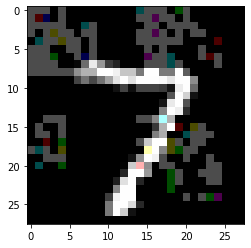

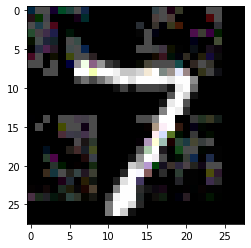

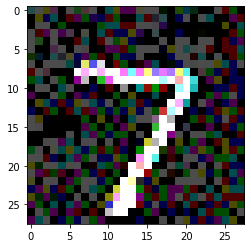

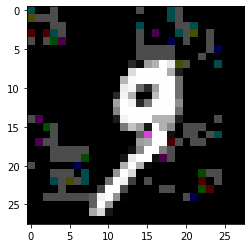

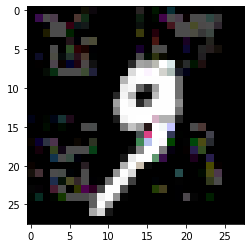

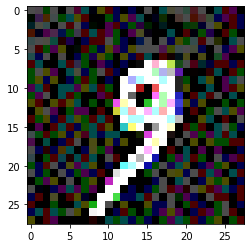

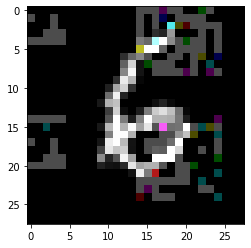

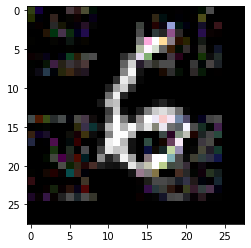

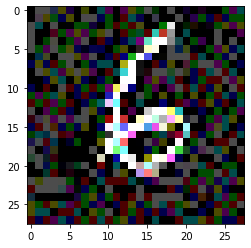

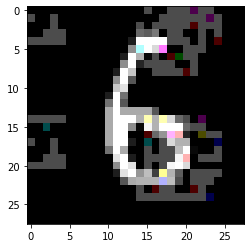

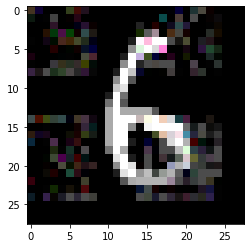

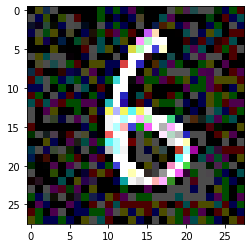

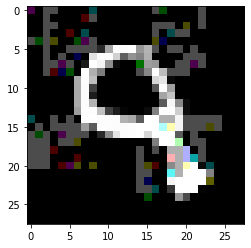

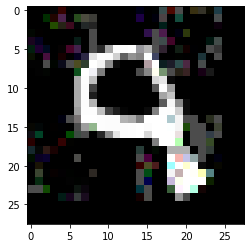

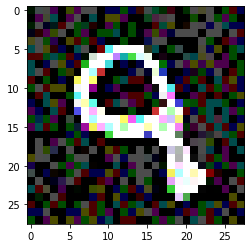

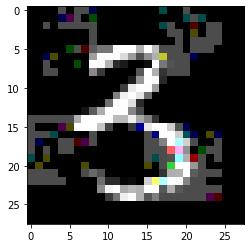

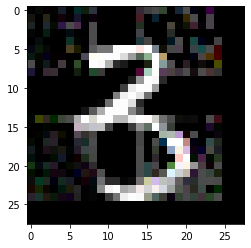

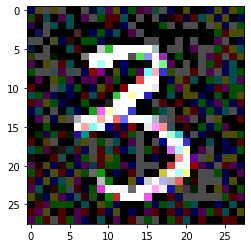

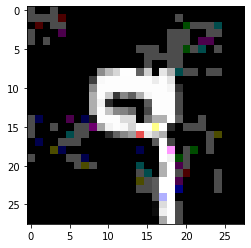

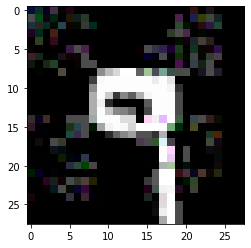

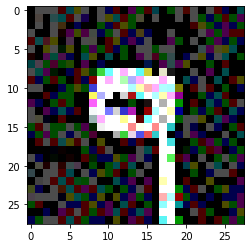

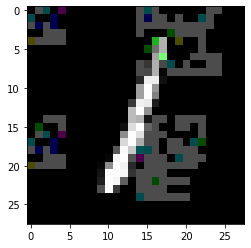

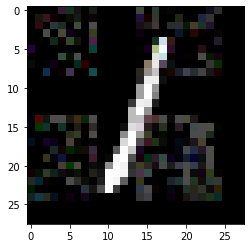

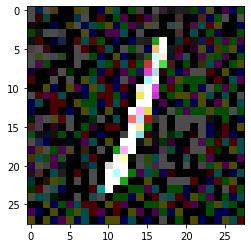

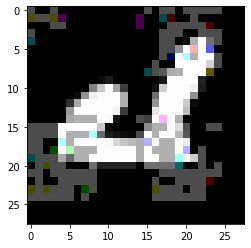

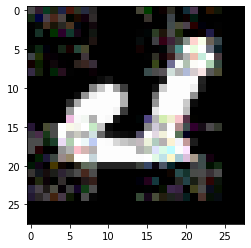

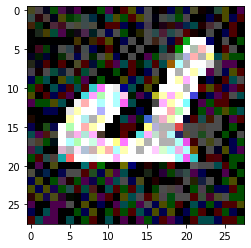

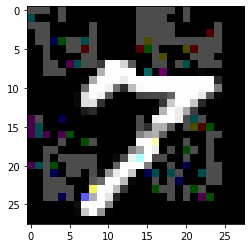

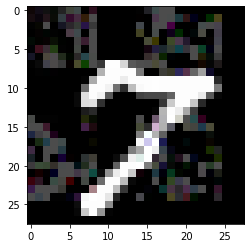

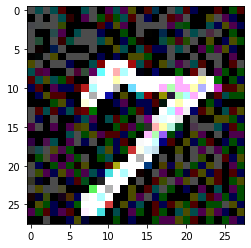

In [10]:
#test set 전체 adv 적용
LR_FGSM = np.zeros((10000,28,28,3))
LR_I = np.zeros((10000,28,28,3))
LR_shadow = np.zeros((10000,28,28,3))

for i in range(0, 10000):
    image = x_test_rgb[i]
    image_labels = y_test[i].copy()
    image_labels = tf.expand_dims(image_labels, 0)
    image = image.reshape(-1, img_rows, img_cols, 3)

    #FGSM
    FGSM_perturbations = fast_gradient_method(model_fn = model, x = image, eps = 0.3, norm = np.inf, clip_min = 0, clip_max = 1,y = image_labels, targeted = False ,shadow =False)
    #I-FGSM
    I_perturbations = projected_gradient_descent(model_fn = model, x = image, eps = 0.3 , eps_iter = 0.01, nb_iter = 40, norm = np.inf, clip_min=0, clip_max=1, y=image_labels, targeted=False, rand_init=False, rand_minmax=0.3, sanity_checks=False,shadow=False)  
    #shadow
    shadow_perturbations = projected_gradient_descent(model_fn = model, x = image, eps = 0.3 , eps_iter = 0.01, nb_iter = 40, norm = np.inf, clip_min=0, clip_max=1, y=image_labels, targeted=False, rand_init=True, rand_minmax=0.3, sanity_checks=False,shadow=True)  

    LR_FGSM[i] = FGSM_perturbations
    LR_I[i] = I_perturbations
    LR_shadow[i] = shadow_perturbations

    if i % 1000 == 0 :
        plt.imshow(LR_FGSM[i])
        plt.show()
        plt.imshow(LR_I[i])
        plt.show()
        plt.imshow(LR_shadow[i])
        plt.show()

In [11]:
LR_FGSM_loss, LR_FGSM_acc = model.evaluate(LR_FGSM, y_test,batch_size=16)
LR_I_loss, LR_I_acc = model.evaluate(LR_I, y_test,batch_size=16)
LR_shadow_loss, LR_shadow_acc = model.evaluate(LR_shadow, y_test,batch_size=16)

625/625 [==============================] - 3s 4ms/step - loss: 22.7412 - accuracy: 0.1820


In [12]:
'''
LR IMAGE BICUBIC, RGB->YCbCr
'''
x_test_small = np.zeros((10000,14,14,3),np.float32)
x_test_bicubic = np.zeros((10000,28,28,3),np.float32)
x_test_ycbcr = np.zeros((10000,28,28,3),np.float32)

for i in range(10000):
  x_test_small[i] = cv2.resize(x_test_rgb[i],None, fx = 0.5, fy = 0.5, interpolation=cv2.INTER_CUBIC)
  x_test_bicubic[i] = cv2.resize(x_test_small[i],None, fx = 2, fy = 2, interpolation=cv2.INTER_CUBIC)
  x_test_ycbcr[i] = cv2.cvtColor(x_test_bicubic[i], cv2.COLOR_RGB2YCrCb)

x_test_y = x_test_ycbcr[:,:,:,0]

In [25]:
print(x_test_rgb.max())
print(x_test_small.max())
print(x_test_bicubic.max())
print(x_test_ycbcr.max())

1.0
1.2956073
1.471482
1.471482


In [21]:
'''
LR BICUBIC IMAGE ACC
'''
BI_loss, BI_acc = model.evaluate(x_test_bicubic, y_test,batch_size=16)

625/625 [==============================] - 3s 4ms/step - loss: 0.4320 - accuracy: 0.8526


In [26]:
'''
LR(+noise) IMAGE BICUBIC, RGB->YCbCr, extract Y
'''
x_test_FGSM_small = np.zeros((10000,14,14,3),np.float32)
x_test_FGSM_bicubic = np.zeros((10000,28,28,3),np.float32)
x_test_FGSM_ycbcr = np.zeros((10000,28,28,3),np.float32)

x_test_I_small = np.zeros((10000,14,14,3),np.float32)
x_test_I_bicubic = np.zeros((10000,28,28,3),np.float32)
x_test_I_ycbcr = np.zeros((10000,28,28,3),np.float32)

x_test_shadow_small = np.zeros((10000,14,14,3),np.float32)
x_test_shadow_bicubic = np.zeros((10000,28,28,3),np.float32)
x_test_shadow_ycbcr = np.zeros((10000,28,28,3),np.float32)

for i in range(10000):
  x_test_FGSM_small[i] = cv2.resize(LR_FGSM[i],None, fx = 0.5, fy = 0.5, interpolation=cv2.INTER_CUBIC)
  x_test_FGSM_bicubic[i] = cv2.resize(x_test_FGSM_small[i],None, fx = 2, fy = 2, interpolation=cv2.INTER_CUBIC)
  x_test_FGSM_ycbcr[i] = cv2.cvtColor(x_test_FGSM_bicubic[i], cv2.COLOR_RGB2YCrCb)

  x_test_I_small[i] = cv2.resize(LR_I[i],None, fx = 0.5, fy = 0.5, interpolation=cv2.INTER_CUBIC)
  x_test_I_bicubic[i] = cv2.resize(x_test_I_small[i],None, fx = 2, fy = 2, interpolation=cv2.INTER_CUBIC)
  x_test_I_ycbcr[i] = cv2.cvtColor(x_test_I_bicubic[i], cv2.COLOR_RGB2YCrCb)

  x_test_shadow_small[i] = cv2.resize(LR_shadow[i],None, fx = 0.5, fy = 0.5, interpolation=cv2.INTER_CUBIC)
  x_test_shadow_bicubic[i] = cv2.resize(x_test_shadow_small[i],None, fx = 2, fy = 2, interpolation=cv2.INTER_CUBIC)
  x_test_shadow_ycbcr[i] = cv2.cvtColor(x_test_shadow_bicubic[i], cv2.COLOR_RGB2YCrCb)

x_test_FGSM_y = x_test_FGSM_ycbcr[:,:,:,0]
x_test_I_y = x_test_I_ycbcr[:,:,:,0]
x_test_shadow_y = x_test_shadow_ycbcr[:,:,:,0]

In [38]:
'''
LR(+noise) BICUBIC IMAGE ACC
'''
BI_FGSM_loss, BI_FGSM_acc = model.evaluate(x_test_FGSM_bicubic, y_test,batch_size=16)
BI_I_loss, BI_I_acc = model.evaluate(x_test_I_bicubic, y_test,batch_size=16)
BI_shadow_loss, BI_shadow_acc = model.evaluate(LR_shadow, y_test,batch_size=16)

625/625 [==============================] - 3s 4ms/step - loss: 22.7412 - accuracy: 0.1820


In [29]:
'''
LR IMAGE(Y Channel) VDSR
'''
#VDSR
x_test_y_out = np.zeros((10000,28,28))

for i in range(10000):
    im_input = x_test_y[i]
    im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])
    model_torch = model_torch.cuda()
    im_input = im_input.cuda()

    out = model_torch(im_input)
    out = out.cpu()
    im_out = out.data[0].numpy()

    im_out[im_out < 0] = 0
    im_out[im_out > 1.] = 1.

    x_test_y_out[i] = im_out

x_test_y_out = x_test_y_out.reshape((-1, img_rows, img_cols, channels))

#Y채널을 YCbCr 채널로 합치기
x_test_out = np.zeros((10000,28,28,3),np.float32)

for i in range(10000):
  x_test_out[i,:,:,0] = x_test_y_out[i,:,:,0]
  x_test_out[i,:,:,1] = x_test_ycbcr[i,:,:,1]
  x_test_out[i,:,:,2] = x_test_ycbcr[i,:,:,2]

#YCbCr -> RGB변환
x_test_HR = np.zeros((10000,28,28,3),np.float32)

for i in range(10000):
  x_test_HR[i] = cv2.cvtColor(x_test_out[i], cv2.COLOR_YCrCb2RGB)

x_test_HR[x_test_HR < 0] = 0
x_test_HR[x_test_HR > 1.] = 1.

#check HR acc
HR_loss, HR_acc = model.evaluate(x_test_HR, y_test,batch_size=16)

625/625 [==============================] - 2s 4ms/step - loss: 0.2745 - accuracy: 0.9119


In [30]:
'''
LR(+FGSM) IMAGE(Y Channel) VDSR
x_test_FGSM_y 
'''
#VDSR
x_test_FGSM_y_out = np.zeros((10000,28,28))

for i in range(10000):
    im_input = x_test_FGSM_y[i]
    im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])
    model_torch = model_torch.cuda()
    im_input = im_input.cuda()

    out = model_torch(im_input)
    out = out.cpu()
    im_out = out.data[0].numpy()

    im_out[im_out < 0] = 0
    im_out[im_out > 1.] = 1.

    x_test_FGSM_y_out[i] = im_out

x_test_FGSM_y_out = x_test_FGSM_y_out.reshape((-1, img_rows, img_cols, channels))

#Y채널을 YCbCr 채널로 합치기
x_test_FGSM_out = np.zeros((10000,28,28,3),np.float32)

for i in range(10000):
  x_test_FGSM_out[i,:,:,0] = x_test_FGSM_y_out[i,:,:,0]
  x_test_FGSM_out[i,:,:,1] = x_test_FGSM_ycbcr[i,:,:,1]
  x_test_FGSM_out[i,:,:,2] = x_test_FGSM_ycbcr[i,:,:,2]

#YCbCr -> RGB변환
x_test_FGSM_HR = np.zeros((10000,28,28,3),np.float32)

for i in range(10000):
  x_test_FGSM_HR[i] = cv2.cvtColor(x_test_FGSM_out[i], cv2.COLOR_YCrCb2RGB)

x_test_FGSM_HR[x_test_FGSM_HR < 0] = 0
x_test_FGSM_HR[x_test_FGSM_HR > 1.] = 1.

#check HR acc
HR_loss, HR_acc = model.evaluate(x_test_FGSM_HR, y_test,batch_size=16)

625/625 [==============================] - 2s 4ms/step - loss: 6.5281 - accuracy: 0.1315


In [31]:
'''
LR(+I_FGSM) IMAGE(Y Channel) VDSR 
x_test_I_y  
'''
#VDSR
x_test_I_y_out = np.zeros((10000,28,28))

for i in range(10000):
    im_input = x_test_I_y[i]
    im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])
    model_torch = model_torch.cuda()
    im_input = im_input.cuda()

    out = model_torch(im_input)
    out = out.cpu()
    im_out = out.data[0].numpy()

    im_out[im_out < 0] = 0
    im_out[im_out > 1.] = 1.

    x_test_I_y_out[i] = im_out

x_test_I_y_out = x_test_I_y_out.reshape((-1, img_rows, img_cols, channels))

#Y채널을 YCbCr 채널로 합치기
x_test_I_out = np.zeros((10000,28,28,3),np.float32)

for i in range(10000):
  x_test_I_out[i,:,:,0] = x_test_I_y_out[i,:,:,0]
  x_test_I_out[i,:,:,1] = x_test_I_ycbcr[i,:,:,1]
  x_test_I_out[i,:,:,2] = x_test_I_ycbcr[i,:,:,2]

#YCbCr -> RGB변환
x_test_I_HR = np.zeros((10000,28,28,3),np.float32)

for i in range(10000):
  x_test_I_HR[i] = cv2.cvtColor(x_test_I_out[i], cv2.COLOR_YCrCb2RGB)

x_test_I_HR[x_test_I_HR < 0] = 0
x_test_I_HR[x_test_I_HR > 1.] = 1.

#check HR acc
HR_loss, HR_acc = model.evaluate(x_test_I_HR, y_test,batch_size=16)

625/625 [==============================] - 2s 4ms/step - loss: 9.8068 - accuracy: 0.0501


In [32]:
'''
LR(+shadow) IMAGE(Y Channel) VDSR 
x_test_I_y  
'''
#VDSR
x_test_shadow_y_out = np.zeros((10000,28,28))

for i in range(10000):
    im_input = x_test_shadow_y[i]
    im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])
    model_torch = model_torch.cuda()
    im_input = im_input.cuda()

    out = model_torch(im_input)
    out = out.cpu()
    im_out = out.data[0].numpy()

    im_out[im_out < 0] = 0
    im_out[im_out > 1.] = 1.

    x_test_shadow_y_out[i] = im_out

x_test_shadow_y_out = x_test_shadow_y_out.reshape((-1, img_rows, img_cols, channels))

#Y채널을 YCbCr 채널로 합치기
x_test_shadow_out = np.zeros((10000,28,28,3),np.float32)

for i in range(10000):
  x_test_shadow_out[i,:,:,0] = x_test_shadow_y_out[i,:,:,0]
  x_test_shadow_out[i,:,:,1] = x_test_shadow_ycbcr[i,:,:,1]
  x_test_shadow_out[i,:,:,2] = x_test_shadow_ycbcr[i,:,:,2]

#YCbCr -> RGB변환
x_test_shadow_HR = np.zeros((10000,28,28,3),np.float32)

for i in range(10000):
  x_test_shadow_HR[i] = cv2.cvtColor(x_test_shadow_out[i], cv2.COLOR_YCrCb2RGB)

x_test_shadow_HR[x_test_shadow_HR < 0] = 0
x_test_shadow_HR[x_test_shadow_HR > 1.] = 1.

#check HR acc
HR_loss, HR_acc = model.evaluate(x_test_shadow_HR, y_test,batch_size=16)

625/625 [==============================] - 2s 4ms/step - loss: 9.5995 - accuracy: 0.2238


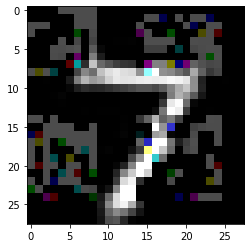

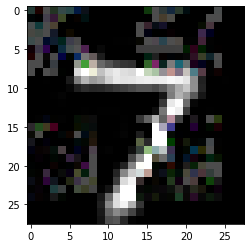

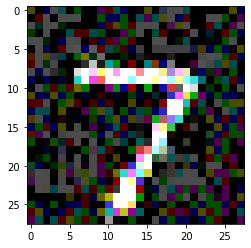

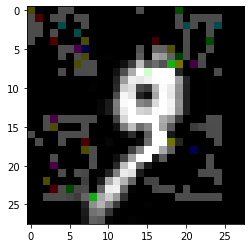

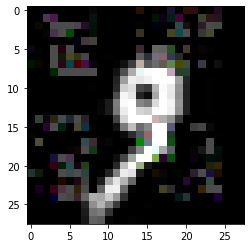

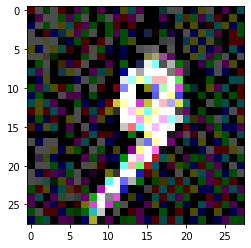

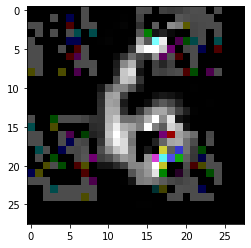

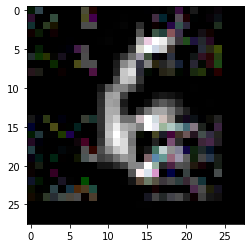

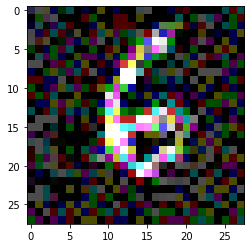

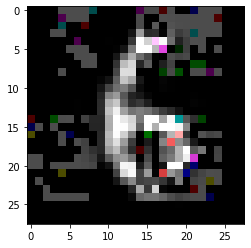

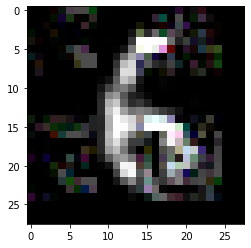

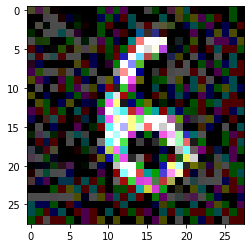

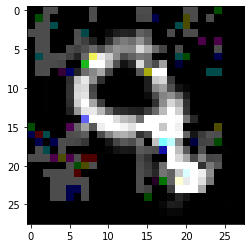

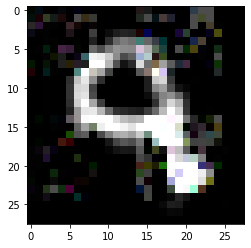

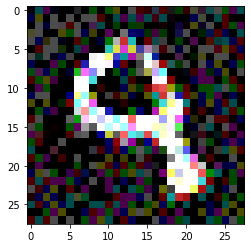

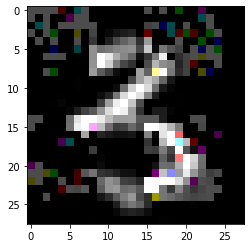

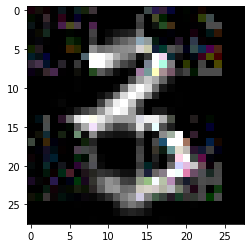

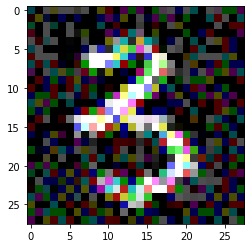

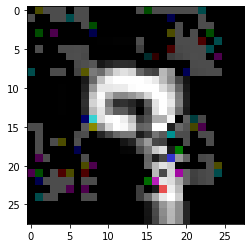

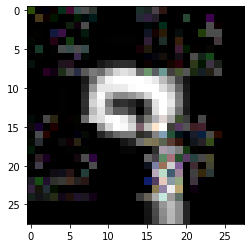

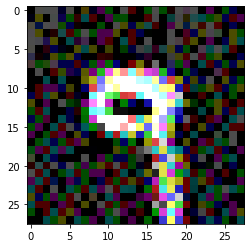

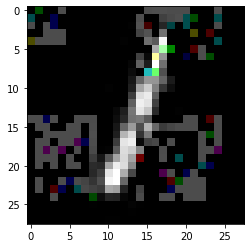

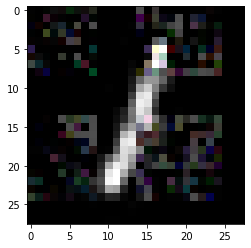

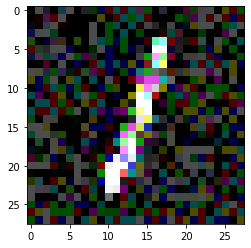

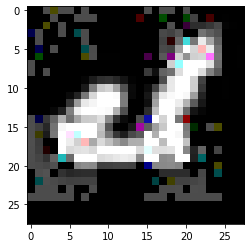

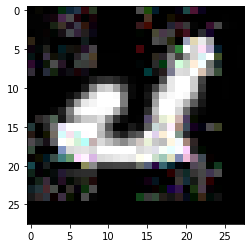

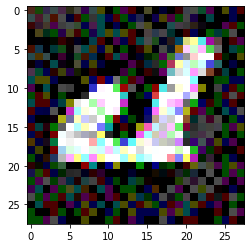

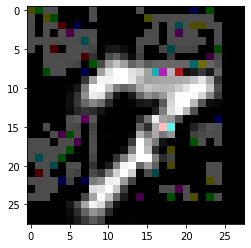

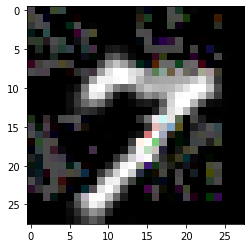

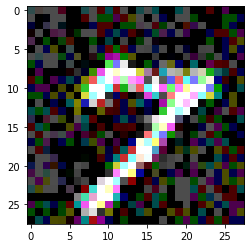

In [36]:
'''
BICUBIC(+noise)
'''
BI_FGSM = np.zeros((10000,28,28,3))
BI_I = np.zeros((10000,28,28,3))
BI_shadow = np.zeros((10000,28,28,3))

for i in range(0, 10000):
    image = x_test_bicubic[i].copy()
    image_labels = y_test[i].copy()
    image_labels = tf.expand_dims(image_labels, 0)
    image = image.reshape(-1, img_rows, img_cols, 3)

    #FGSM
    FGSM_perturbations = fast_gradient_method(model_fn = model, x = image, eps = 0.3, norm = np.inf, clip_min = 0, clip_max = 1,y = image_labels, targeted = False ,shadow =False)
    #I-FGSM
    I_perturbations = projected_gradient_descent(model_fn = model, x = image, eps = 0.3 , eps_iter = 0.01, nb_iter = 40, norm = np.inf, clip_min=0, clip_max=1, y=image_labels, targeted=False, rand_init=False, rand_minmax=0.3, sanity_checks=False,shadow=False)  
    #shadow
    shadow_perturbations = projected_gradient_descent(model_fn = model, x = image, eps = 0.3 , eps_iter = 0.01, nb_iter = 40, norm = np.inf, clip_min=0, clip_max=1, y=image_labels, targeted=False, rand_init=True, rand_minmax=0.3, sanity_checks=False,shadow=True)  

    BI_FGSM[i] = FGSM_perturbations
    BI_I[i] = I_perturbations
    BI_shadow[i] = shadow_perturbations

    if i % 1000 == 0 :
        plt.imshow(BI_FGSM[i])
        plt.show()
        plt.imshow(BI_I[i])
        plt.show()
        plt.imshow(BI_shadow[i])
        plt.show()

In [37]:
BI_FGSM_loss, BI_FGSM_acc = model.evaluate(BI_FGSM, y_test,batch_size=16)
BI_I_loss, BI_I_acc = model.evaluate(BI_I, y_test,batch_size=16)
BI_shadow_loss, BI_shadow_acc = model.evaluate(BI_shadow, y_test,batch_size=16)

625/625 [==============================] - 2s 4ms/step - loss: 23.5743 - accuracy: 0.1639


In [48]:
'''
BICUBIC(+noise) RGB->YCbCr extract Y
'''
BI_FGSM = BI_FGSM.astype(np.float32)
BI_I = BI_I.astype(np.float32)
BI_shadow = BI_shadow.astype(np.float32)

x_test_BI_FGSM_ycbcr = np.zeros((10000,28,28,3),np.float32)
x_test_BI_I_ycbcr = np.zeros((10000,28,28,3),np.float32)
x_test_BI_shadow_ycbcr = np.zeros((10000,28,28,3),np.float32)

for i in range(10000):
  x_test_BI_FGSM_ycbcr[i] = cv2.cvtColor(BI_FGSM[i], cv2.COLOR_RGB2YCrCb)

  x_test_BI_I_ycbcr[i] = cv2.cvtColor(BI_I[i] , cv2.COLOR_RGB2YCrCb)

  x_test_BI_shadow_ycbcr[i] = cv2.cvtColor(BI_shadow[i], cv2.COLOR_RGB2YCrCb)

x_test_BI_FGSM_y = x_test_BI_FGSM_ycbcr[:,:,:,0]
x_test_BI_I_y = x_test_BI_I_ycbcr[:,:,:,0]
x_test_BI_shadow_y = x_test_BI_shadow_ycbcr[:,:,:,0]

In [49]:
'''
BICUBIC(+FGSM) IMAGE(Y Channel) VDSR
x_test_BI_FGSM_ycbcr 
'''
#VDSR
x_test_BI_FGSM_y_out = np.zeros((10000,28,28))

for i in range(10000):
    im_input = x_test_BI_FGSM_y[i]
    im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])
    model_torch = model_torch.cuda()
    im_input = im_input.cuda()

    out = model_torch(im_input)
    out = out.cpu()
    im_out = out.data[0].numpy()

    im_out[im_out < 0] = 0
    im_out[im_out > 1.] = 1.

    x_test_BI_FGSM_y_out[i] = im_out

x_test_BI_FGSM_y_out = x_test_BI_FGSM_y_out.reshape((-1, img_rows, img_cols, channels))

#Y채널을 YCbCr 채널로 합치기
x_test_BI_FGSM_out = np.zeros((10000,28,28,3),np.float32)

for i in range(10000):
  x_test_BI_FGSM_out[i,:,:,0] = x_test_BI_FGSM_y_out[i,:,:,0]
  x_test_BI_FGSM_out[i,:,:,1] = x_test_BI_FGSM_ycbcr[i,:,:,1]
  x_test_BI_FGSM_out[i,:,:,2] = x_test_BI_FGSM_ycbcr[i,:,:,2]

#YCbCr -> RGB변환
x_test_BI_FGSM_HR = np.zeros((10000,28,28,3),np.float32)

for i in range(10000):
  x_test_BI_FGSM_HR[i] = cv2.cvtColor(x_test_BI_FGSM_out[i], cv2.COLOR_YCrCb2RGB)

x_test_BI_FGSM_HR[x_test_BI_FGSM_HR < 0] = 0
x_test_BI_FGSM_HR[x_test_BI_FGSM_HR > 1.] = 1.

#check HR acc
HR_loss, HR_acc = model.evaluate(x_test_BI_FGSM_HR, y_test,batch_size=16)

625/625 [==============================] - 2s 4ms/step - loss: 10.4252 - accuracy: 0.0240


In [51]:
'''
BICUBIC(+I) IMAGE(Y Channel) VDSR
x_test_BI_I_ycbcr 
'''
#VDSR
x_test_BI_I_y_out = np.zeros((10000,28,28))

for i in range(10000):
    im_input = x_test_BI_I_y[i]
    im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])
    model_torch = model_torch.cuda()
    im_input = im_input.cuda()

    out = model_torch(im_input)
    out = out.cpu()
    im_out = out.data[0].numpy()

    im_out[im_out < 0] = 0
    im_out[im_out > 1.] = 1.

    x_test_BI_I_y_out[i] = im_out

x_test_BI_I_y_out = x_test_BI_I_y_out.reshape((-1, img_rows, img_cols, channels))

#Y채널을 YCbCr 채널로 합치기
x_test_BI_I_out = np.zeros((10000,28,28,3),np.float32)

for i in range(10000):
  x_test_BI_I_out[i,:,:,0] = x_test_BI_I_y_out[i,:,:,0]
  x_test_BI_I_out[i,:,:,1] = x_test_BI_I_ycbcr[i,:,:,1]
  x_test_BI_I_out[i,:,:,2] = x_test_BI_I_ycbcr[i,:,:,2]

#YCbCr -> RGB변환
x_test_BI_I_HR = np.zeros((10000,28,28,3),np.float32)

for i in range(10000):
  x_test_BI_I_HR[i] = cv2.cvtColor(x_test_BI_I_out[i], cv2.COLOR_YCrCb2RGB)

x_test_BI_I_HR[x_test_BI_I_HR < 0] = 0
x_test_BI_I_HR[x_test_BI_I_HR > 1.] = 1.

#check HR acc
HR_loss, HR_acc = model.evaluate(x_test_BI_I_HR, y_test,batch_size=16)

625/625 [==============================] - 2s 4ms/step - loss: 27.1830 - accuracy: 0.0000e+00


In [52]:
'''
BICUBIC(+shadow) IMAGE(Y Channel) VDSR
x_test_BI_shadow_ycbcr 
'''
#VDSR
x_test_BI_shadow_y_out = np.zeros((10000,28,28))

for i in range(10000):
    im_input = x_test_BI_shadow_y[i]
    im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])
    model_torch = model_torch.cuda()
    im_input = im_input.cuda()

    out = model_torch(im_input)
    out = out.cpu()
    im_out = out.data[0].numpy()

    im_out[im_out < 0] = 0
    im_out[im_out > 1.] = 1.

    x_test_BI_shadow_y_out[i] = im_out

x_test_BI_shadow_y_out = x_test_BI_shadow_y_out.reshape((-1, img_rows, img_cols, channels))

#Y채널을 YCbCr 채널로 합치기
x_test_BI_shadow_out = np.zeros((10000,28,28,3),np.float32)

for i in range(10000):
  x_test_BI_shadow_out[i,:,:,0] = x_test_BI_shadow_y_out[i,:,:,0]
  x_test_BI_shadow_out[i,:,:,1] = x_test_BI_shadow_ycbcr[i,:,:,1]
  x_test_BI_shadow_out[i,:,:,2] = x_test_BI_shadow_ycbcr[i,:,:,2]

#YCbCr -> RGB변환
x_test_BI_shadow_HR = np.zeros((10000,28,28,3),np.float32)

for i in range(10000):
  x_test_BI_shadow_HR[i] = cv2.cvtColor(x_test_BI_shadow_out[i], cv2.COLOR_YCrCb2RGB)

x_test_BI_shadow_HR[x_test_BI_shadow_HR < 0] = 0
x_test_BI_shadow_HR[x_test_BI_shadow_HR > 1.] = 1.

#check HR acc
HR_loss, HR_acc = model.evaluate(x_test_BI_shadow_HR, y_test,batch_size=16)

625/625 [==============================] - 2s 4ms/step - loss: 21.4308 - accuracy: 0.1641


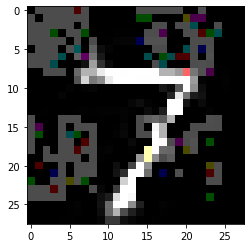

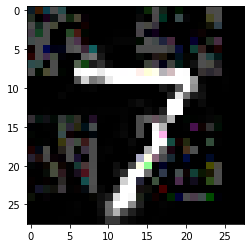

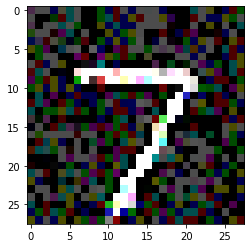

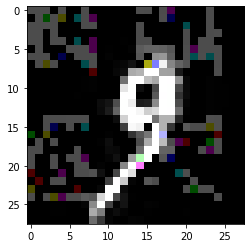

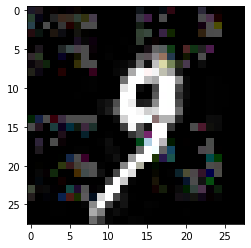

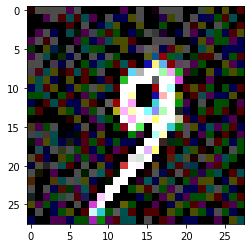

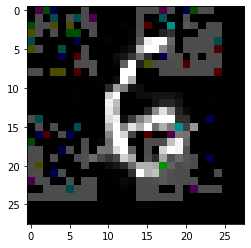

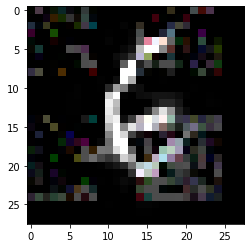

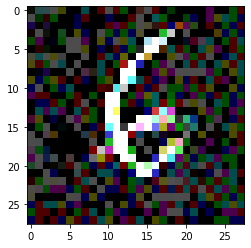

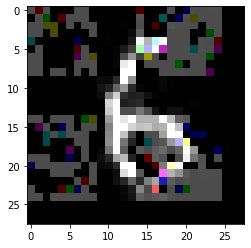

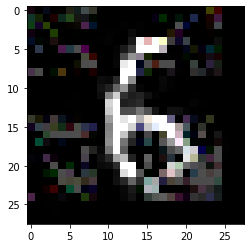

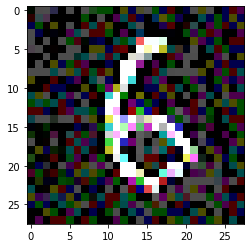

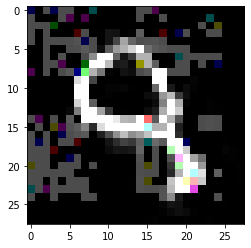

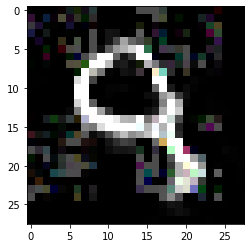

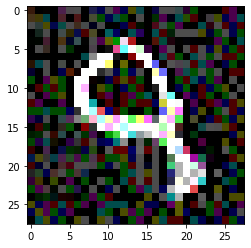

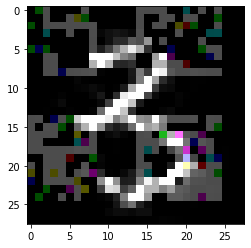

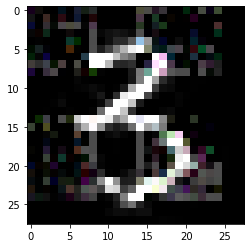

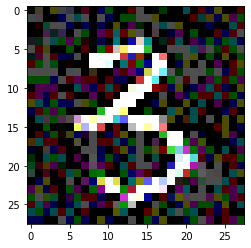

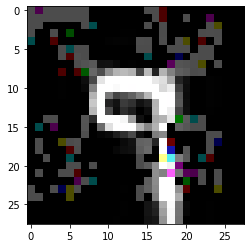

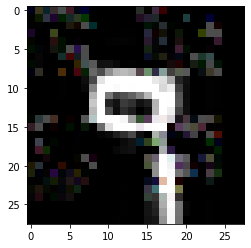

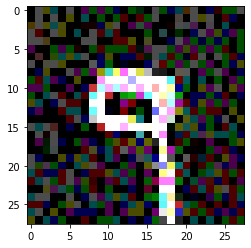

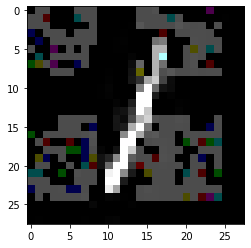

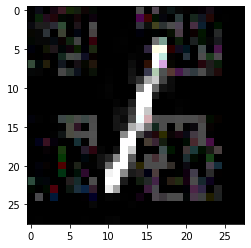

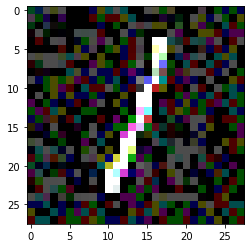

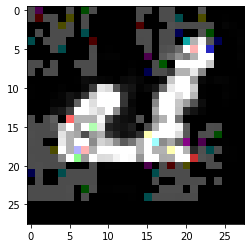

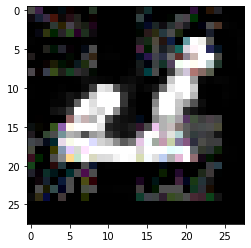

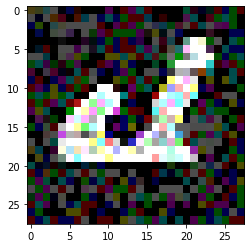

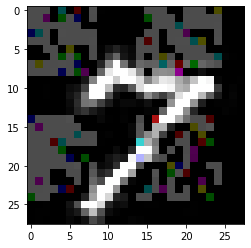

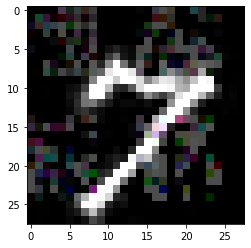

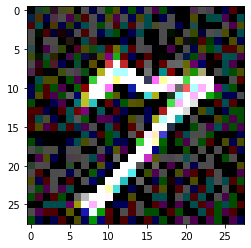

In [53]:
'''
HR(+noise)
'''
HR_FGSM = np.zeros((10000,28,28,3))
HR_I = np.zeros((10000,28,28,3))
HR_shadow = np.zeros((10000,28,28,3))

for i in range(0, 10000):
    image = x_test_HR[i].copy()
    image_labels = y_test[i].copy()
    image_labels = tf.expand_dims(image_labels, 0)
    image = image.reshape(-1, img_rows, img_cols, 3)

    #FGSM
    FGSM_perturbations = fast_gradient_method(model_fn = model, x = image, eps = 0.3, norm = np.inf, clip_min = 0, clip_max = 1,y = image_labels, targeted = False ,shadow =False)
    #I-FGSM
    I_perturbations = projected_gradient_descent(model_fn = model, x = image, eps = 0.3 , eps_iter = 0.01, nb_iter = 40, norm = np.inf, clip_min=0, clip_max=1, y=image_labels, targeted=False, rand_init=False, rand_minmax=0.3, sanity_checks=False,shadow=False)  
    #shadow
    shadow_perturbations = projected_gradient_descent(model_fn = model, x = image, eps = 0.3 , eps_iter = 0.01, nb_iter = 40, norm = np.inf, clip_min=0, clip_max=1, y=image_labels, targeted=False, rand_init=True, rand_minmax=0.3, sanity_checks=False,shadow=True)  

    HR_FGSM[i] = FGSM_perturbations
    HR_I[i] = I_perturbations
    HR_shadow[i] = shadow_perturbations

    if i % 1000 == 0 :
        plt.imshow(HR_FGSM[i])
        plt.show()
        plt.imshow(HR_I[i])
        plt.show()
        plt.imshow(HR_shadow[i])
        plt.show()

In [54]:
HR_FGSM_loss, BI_FGSM_acc = model.evaluate(HR_FGSM, y_test,batch_size=16)
HR_I_loss, BI_I_acc = model.evaluate(HR_I, y_test,batch_size=16)
HR_shadow_loss, BI_shadow_acc = model.evaluate(HR_shadow, y_test,batch_size=16)

625/625 [==============================] - 2s 4ms/step - loss: 24.3522 - accuracy: 0.1525


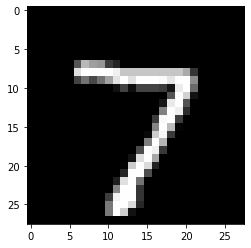

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


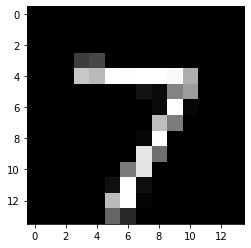

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


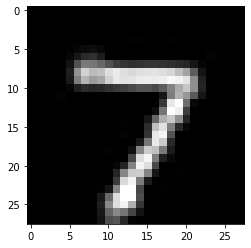

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


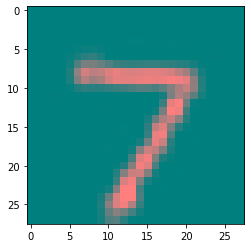

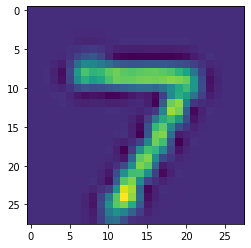

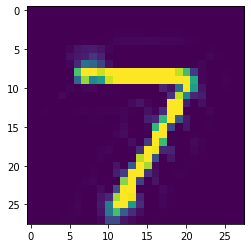

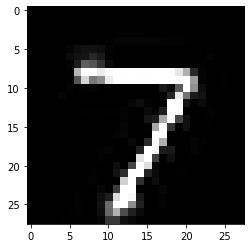

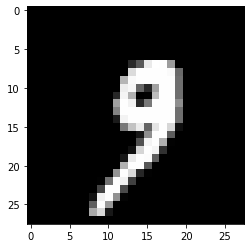

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


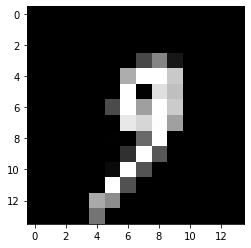

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


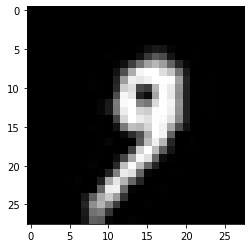

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


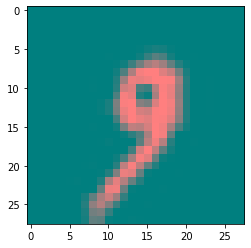

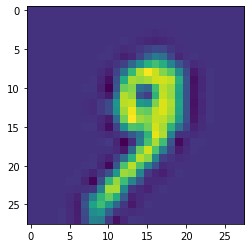

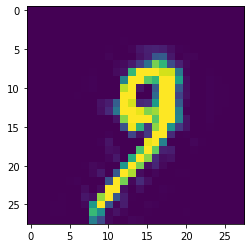

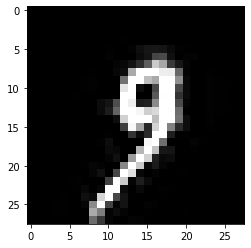

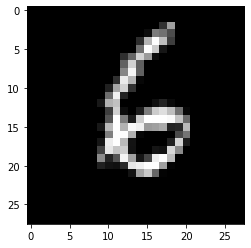

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


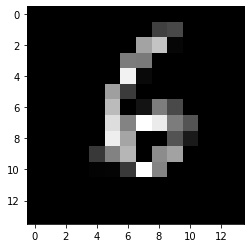

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


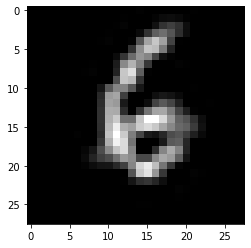

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


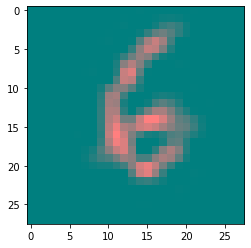

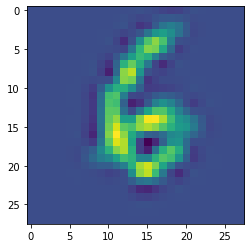

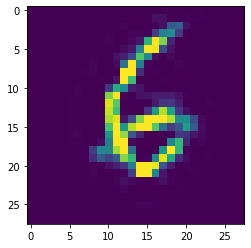

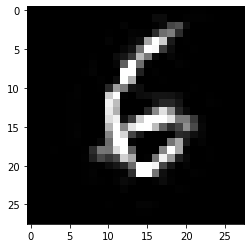

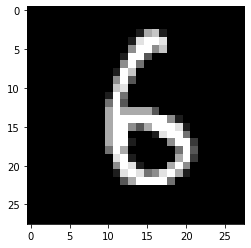

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


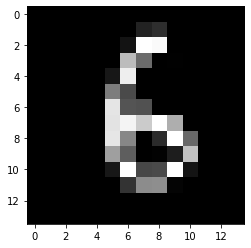

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


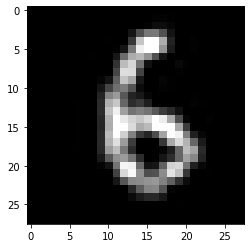

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


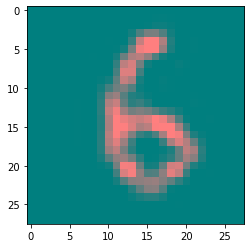

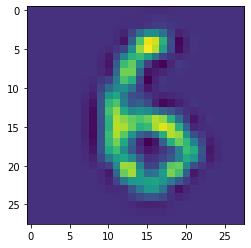

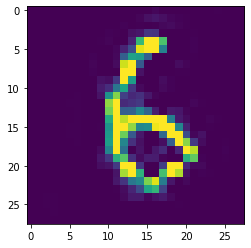

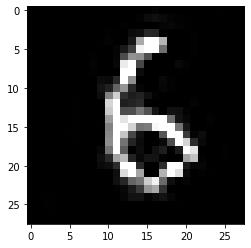

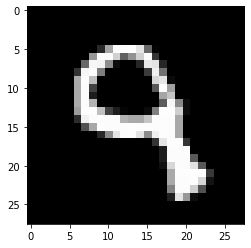

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


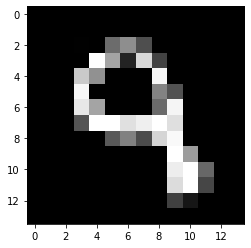

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


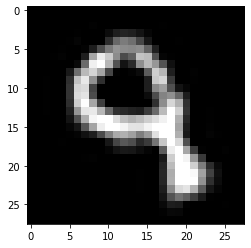

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


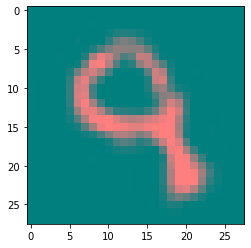

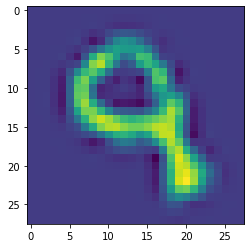

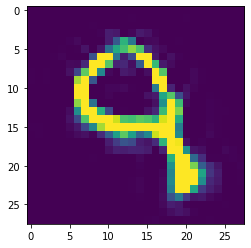

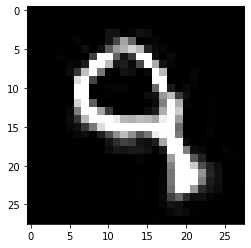

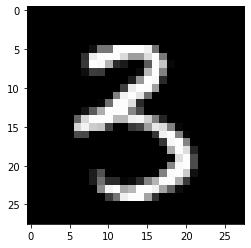

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


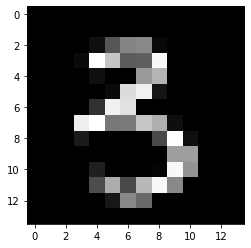

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


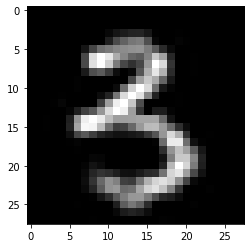

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


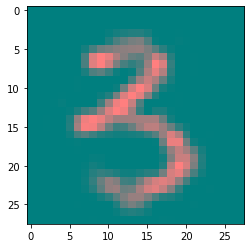

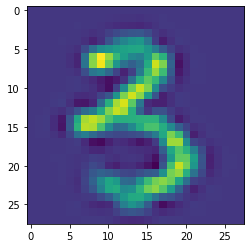

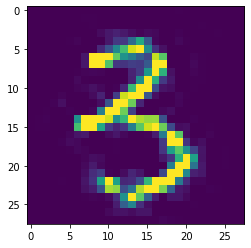

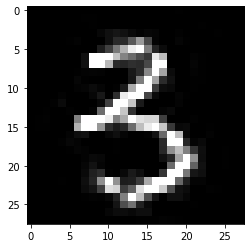

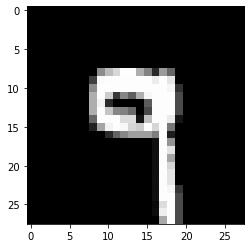

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


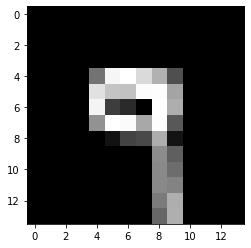

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


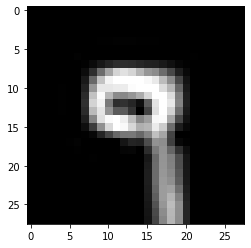

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


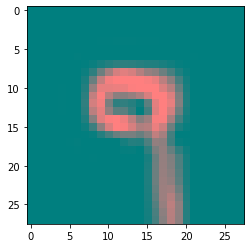

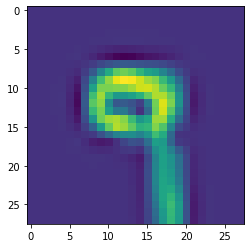

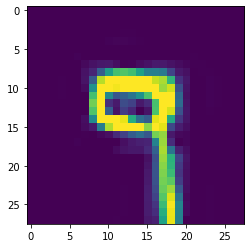

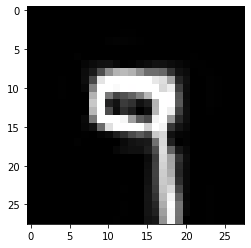

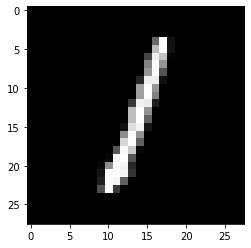

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


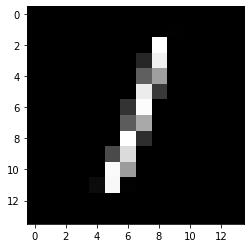

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


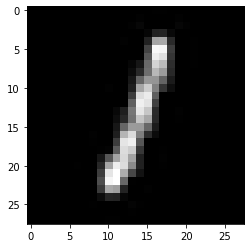

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


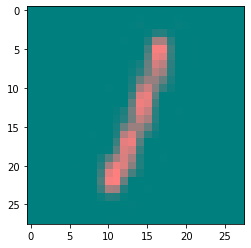

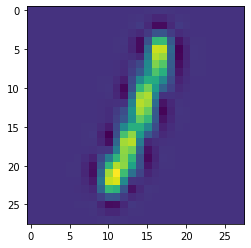

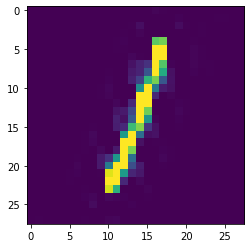

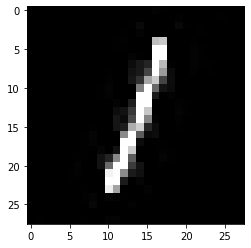

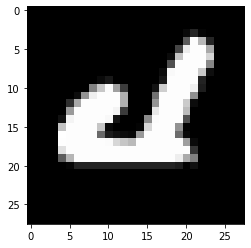

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


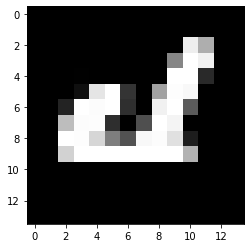

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


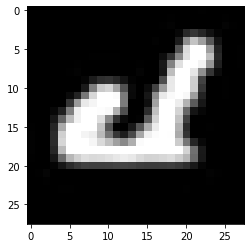

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


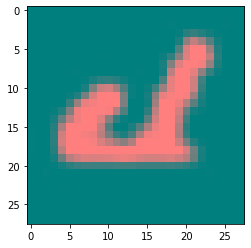

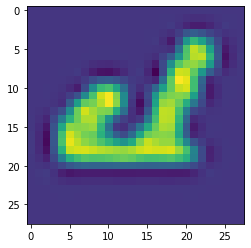

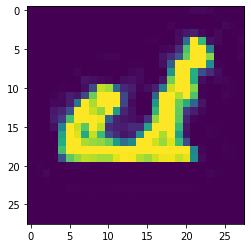

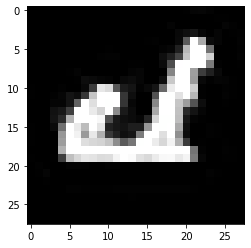

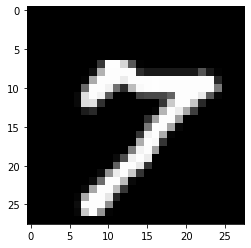

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


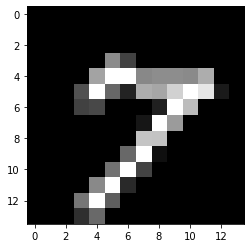

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


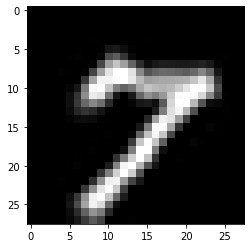

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


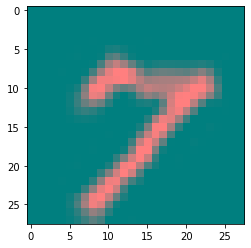

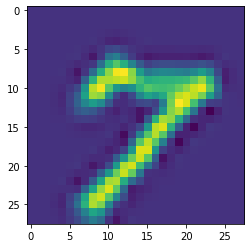

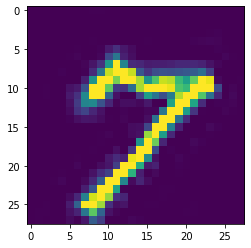

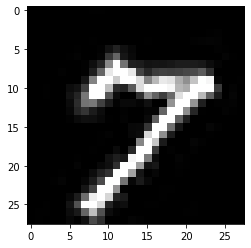

In [20]:
for i in range(10000):
  if i % 1000 == 0:
    plt.imshow(x_test_rgb[i])
    plt.show()    
    plt.imshow(x_test_small[i])
    plt.show()
    plt.imshow(x_test_bicubic[i])
    plt.show()
    plt.imshow(x_test_ycbcr[i])
    plt.show()
    plt.imshow(x_test_y[i])
    plt.show()
    plt.imshow(x_test_y_out[i,:,:,0])
    plt.show()
    plt.imshow(x_test_HR[i])
    plt.show()